KAN

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import timeit
from kan import *


torch.set_default_dtype(torch.float64)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# create a KAN: 2D inputs, 1D output, and 5 hidden neurons. cubic spline (k=3), 5 grid intervals (grid=5).
model = KAN(width=[2,5,1], grid=3, k=3, seed=42, device=device)

cpu
checkpoint directory created: ./model
saving model version 0.0


In [4]:
from kan.utils import create_dataset
# create dataset f(x,y) = exp(sin(pi*x)+y^2)
f = lambda x: torch.cos(torch.pi*x[:,[0]] * x[:,[1]])
f_with_noise = lambda x: f(x) + torch.normal(mean=0.6, std=0.1, size=f(x).shape)
dataset = create_dataset(f_with_noise, n_var=2, device=device,)
dataset['train_input'].shape, dataset['train_label'].shape

(torch.Size([1000, 2]), torch.Size([1000, 1]))

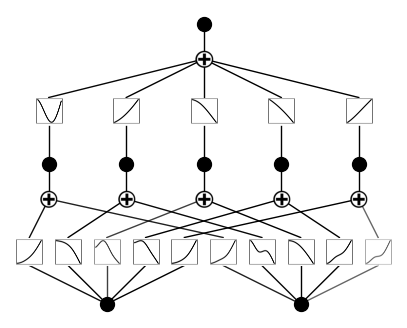

In [5]:
# plot KAN at initialization
model(dataset['train_input'])
model.plot()

In [6]:
# train the model
model.fit(dataset, opt="LBFGS", steps=50, lamb=0.001);

| train_loss: 1.06e-01 | test_loss: 1.09e-01 | reg: 9.82e+00 | : 100%|█| 50/50 [00:28<00:00,  1.76it

saving model version 0.1


In [7]:
number_param = model.n_edge * (model.grid + model.k - 1)
print("number of parameters: ", number_param)

number of parameters:  75


MLPs

In [13]:
x = np.linspace(-1, 1, 2000)  
y = np.linspace(-1, 1, 2000)  
X, Y = np.meshgrid(x, y)  
Z = np.cos(np.pi * X * Y)  + np.random.normal(0.6,.1,2000)


In [14]:

X_flat = np.column_stack((X.ravel(), Y.ravel())) 
Z_flat = Z.ravel()  

X_train, X_test, Z_train, Z_test = train_test_split(X_flat, Z_flat, test_size=0.5, random_state=42)

mlp = MLPRegressor(hidden_layer_sizes=(50, 50), max_iter=10000, activation='relu', solver='sgd')


start = timeit.default_timer()

mlp.fit(X_train, Z_train)

stop = timeit.default_timer()

Z_train_pred = mlp.predict(X_train)
Z_test_pred = mlp.predict(X_test)

train_rmse = np.sqrt(mean_squared_error(Z_train, Z_train_pred))
test_rmse = np.sqrt(mean_squared_error(Z_test, Z_test_pred))

Z_pred = mlp.predict(X_flat).reshape(X.shape)

#fig = plt.figure(figsize=(12, 8))

# # Plot the actual function values
# ax1 = fig.add_subplot(121, projection='3d')
# ax1.plot_surface(X, Y, Z, cmap='viridis')
# ax1.set_title('Actual Function: f(x, y) = exp(sin(pi * x) + y^2)')
# ax1.set_xlabel('X')
# ax1.set_ylabel('Y')
# ax1.set_zlabel('f(x, y)')

# # Plot the predicted function values
# ax2 = fig.add_subplot(122, projection='3d')
# ax2.plot_surface(X, Y, Z_pred, cmap='viridis')
# ax2.set_title('MLP Approximation')
# ax2.set_xlabel('X')
# ax2.set_ylabel('Y')
# ax2.set_zlabel('f(x, y)')

# plt.show()

print(f"Training RMSE: {train_rmse:.6f}")
print(f"Testing RMSE: {test_rmse:.6f}")
print('Time: ', stop - start)  



Training RMSE: 0.104569
Testing RMSE: 0.104571
Time:  66.25942329999816


In [11]:
def calculate_mlp_coefficients(input_size, hidden_layers, output_size):

    total_coefficients = 0
    total_coefficients += input_size * hidden_layers[0] + hidden_layers[0]
    for i in range(len(hidden_layers) - 1):
        total_coefficients += hidden_layers[i] * hidden_layers[i + 1] + hidden_layers[i + 1]
    total_coefficients += hidden_layers[-1] * output_size + output_size

    return total_coefficients

In [12]:
input_size = 2  
hidden_layers = [50, 50]  
output_size = 1 

total_coefficients = calculate_mlp_coefficients(input_size, hidden_layers, output_size)

print(f"O número total de coeficientes no MLP é: {total_coefficients}")

O número total de coeficientes no MLP é: 2751
